# Comparison To Historical Data

This notebook simulates 2018 using the network constrained LOPF functionality and compares the generation output to historical data published by BEIS.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2018-01-01 00:00:00'
end = '2018-12-31 23:00:00'
# year of simulation
year = 2018
# time step as fraction of hour
time_step = 1

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [4]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='historical', merge_generators=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


                     BritNed  EastWest  Moyle  Nemo   IFA  IFA2
2018-01-01 00:00:00      836       432    178   0.0  1701  -1.0
2018-01-01 00:30:00      859       432    187   0.0  1702  -1.0
2018-01-01 01:00:00      715       432    205   0.0  1415  -1.0
2018-01-01 01:30:00      709       432    201   0.0  1404  -1.0
2018-01-01 02:00:00      720       432    211   0.0  1405  -1.0
...                      ...       ...    ...   ...   ...   ...
2018-12-31 21:00:00      716      -535   -454   0.0  1998  -1.0
2018-12-31 21:30:00      716      -536   -439   0.0  1998  -1.0
2018-12-31 22:00:00      862      -536   -424   0.0  1949  -1.0
2018-12-31 22:30:00      777      -535   -454   0.0  1960  -1.0
2018-12-31 23:00:00     -268      -536   -455   0.0  1182  -1.0

[17519 rows x 6 columns]
                     Hywind Scotland Pilot Park (Hywind 2) Demonstrator  \
name                                                                      
2018-01-01 00:00:00                                     

In [5]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, loads, storage_units


To approximate n-1 security and allow room for reactive power flows, don't allow any line to be loaded above 70% of their thermal rating

In [6]:
contingency_factor = 0.7
network.lines.s_max_pu[0:99] *= contingency_factor

LOPF does not account for losses through lines. Here we add a 10% margin to the load in order to account for these losses.

In [7]:
network.loads_t.p_set.iloc[:, 0:29] *= 1.1

## Running the optimisation

In [8]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

AC    29
DC     6
Name: carrier, dtype: int64
INFO:pypsa.linopf:Prepare linear problem
AC    29
DC     6
Name: carrier, dtype: int64
INFO:pypsa.linopf:Total preparation time: 94.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-daj85j89.lp
Reading time = 97.26 seconds
obj: 27785306 rows, 7218241 columns, 49079448 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 27785306 rows, 7218241 columns and 49079448 nonzeros
Model fingerprint: 0xdd0bd0ba
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 1e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 26734122 rows and 52561 columns (presolve time = 7s) ...
Presolve removed 26734122 rows and 239891 columns (presolve time = 10s) ...
Presolve removed 26734122 rows and 3959924 columns (presolve time = 15s) ...
Presolve removed 26734122 rows

INFO:pypsa.linopf:Optimization successful. Objective value: 8.61e+09


('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [9]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

%store p_by_carrier
p_by_carrier

Stored 'p_by_carrier' (DataFrame)


carrier,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),Coal,EfW Incineration,Interconnectors Import,Landfill Gas,Hydro,Natural Gas,Nuclear,Oil,Sewage Sludge Digestion,Shoreline Wave,Small Hydro,Solar Photovoltaics,Tidal Barrage and Tidal Stream,Wind Offshore,Wind Onshore,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,315.200000,0.00,19.929,531.542613,396.576,3163.499962,743.5,312.435669,8408.289311,6833.530000,0.0,50.2,24.0,40.564332,0.0,8.0,5322.763752,6499.869774,0.000000,1128.829000
2018-01-01 01:00:00,315.200000,0.00,0.000,0.000000,396.576,2756.500024,743.5,308.010233,9659.233814,6833.530000,0.0,50.2,24.0,39.989766,0.0,8.0,5318.656864,6233.178739,87.824506,1108.900000
2018-01-01 02:00:00,315.200000,0.00,0.000,0.000000,396.576,2771.499986,743.5,293.406300,9966.011464,6833.530000,0.0,50.2,24.0,38.093700,0.0,8.0,5315.245105,6067.016448,108.320942,1108.900000
2018-01-01 03:00:00,315.200000,0.00,0.000,0.000000,396.576,2626.499986,743.5,247.824325,9089.901296,6833.530000,0.0,50.2,24.0,32.175674,0.0,8.0,5312.001825,5988.198334,64.542325,1108.900000
2018-01-01 04:00:00,315.200000,0.00,0.000,0.000000,396.576,2625.499957,743.5,240.743629,8113.400619,6833.530000,0.0,50.2,24.0,31.256368,0.0,8.0,5306.942938,5794.067604,116.232547,1108.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,313.200000,509.54,2272.563,1961.000000,396.576,3055.999925,743.5,228.226867,15592.283677,6421.493102,0.0,50.2,23.0,30.493284,0.0,8.0,4149.432488,7359.397105,717.694273,3889.003000
2018-12-31 20:00:00,305.369979,509.54,2272.563,1961.000000,396.576,2717.000034,728.8,166.189638,11726.975149,6389.273102,0.0,50.2,23.0,21.663203,0.0,8.0,4517.427141,7497.608542,1459.314444,3866.472979
2018-12-31 21:00:00,305.000000,509.54,2272.563,1961.000000,396.576,2714.000037,717.4,163.239527,9283.591418,6357.053102,0.0,50.2,23.0,21.278649,0.0,8.0,4932.236202,7594.110625,347.661359,3854.703000


Graph the power output of the different generation types...

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

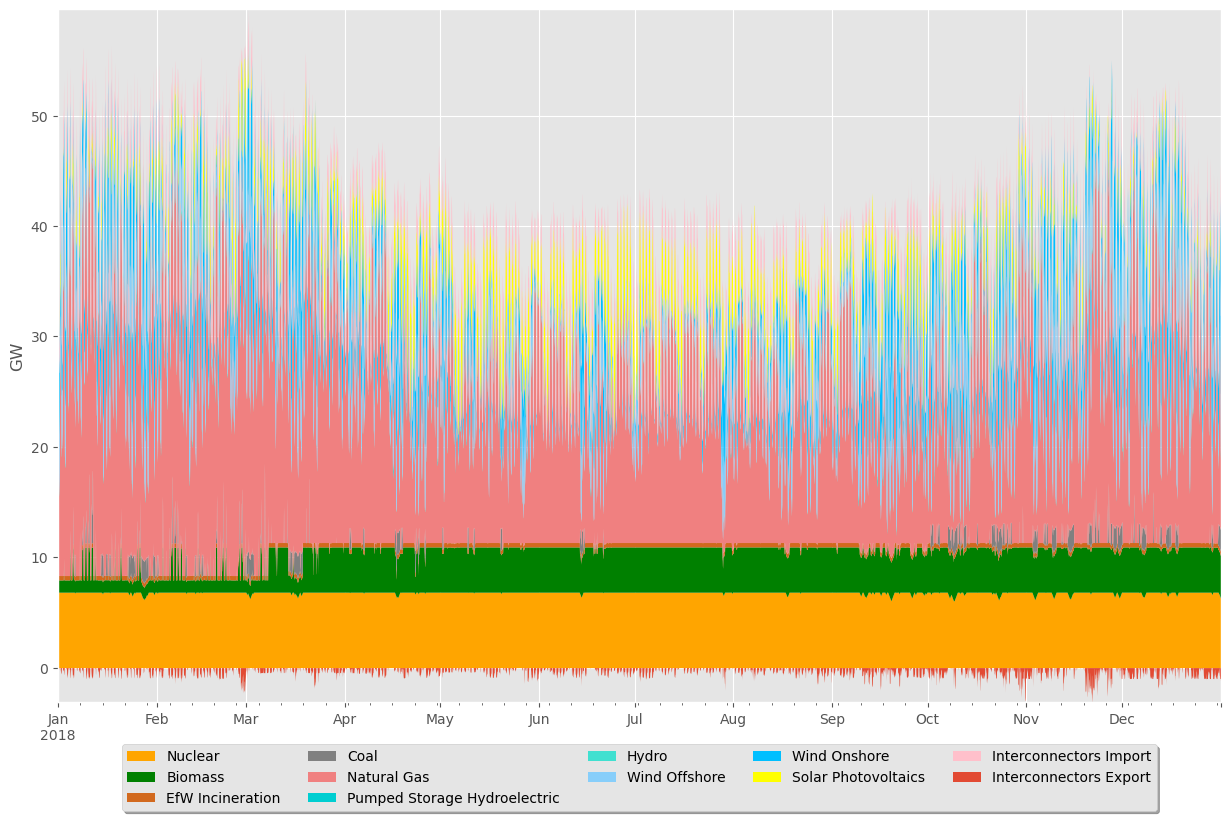

In [10]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration',
        "Coal", "Oil", "Natural Gas",
        "Pumped Storage Hydroelectric", 'Hydro',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Simulated vs historical data power generation

We can group the generators by type and sum to calculate the total simulated power generation over the year in TWh.

In [11]:
%store -r p_by_carrier

p_by_carrier = p_by_carrier.sum() / 1000000
# print(p_by_carrier)
p_by_carrier['Hydro'] = p_by_carrier['Small Hydro'] + p_by_carrier['Hydro']
p_by_carrier['Oil'] = 0.
p_by_carrier.drop(['Small Hydro', 'Anaerobic Digestion', 'Biomass (co-firing)', 'Biomass (dedicated)', 'Landfill Gas', 'Sewage Sludge Digestion', 'Shoreline Wave', 'Tidal Barrage and Tidal Stream'], inplace=True)
p_by_carrier

carrier
Coal                              2.918946
EfW Incineration                  3.474006
Interconnectors Import           21.929185
Hydro                             2.849449
Natural Gas                     139.811284
Nuclear                          59.559250
Oil                               0.000000
Solar Photovoltaics              14.709712
Wind Offshore                    26.046430
Wind Onshore                     28.865750
Pumped Storage Hydroelectric      0.566678
Biomass                          31.103247
dtype: float64

Then the total of all simulated power generation is:

In [12]:
p_by_carrier.sum()

331.8339366483934

BEIS publish reports on power generation. We extracted the data for 2018 from "Table 5c: electricity supplied by fuel 1998 to 2020 (TWh)" in ET5.1 (power generation) and ET5.6 (imports) https://www.gov.uk/government/statistics/electricity-section-5-energy-trends. Additional data for EfW Incineration was obtained from the DUKES dataset https://www.gov.uk/government/collections/digest-of-uk-energy-statistics-dukes.

In [13]:
data = {'Coal': 16.0,
        'EfW Incineration': 3.5,
        'Interconnectors Import': 21.9,
        'Hydro': 5.4,
        'Natural Gas': 129.1,
        'Nuclear': 59.1,
        'Oil': 1.0,
        'Solar Photovoltaics': 12.7,
        'Wind Offshore': 26.5,
        'Wind Onshore': 30.4,
        'Pumped Storage Hydroelectric': 0.0,
        'Biomass': 31.5
        }
data_series = pd.Series(data)
data_series

Coal                             16.0
EfW Incineration                  3.5
Interconnectors Import           21.9
Hydro                             5.4
Natural Gas                     129.1
Nuclear                          59.1
Oil                               1.0
Solar Photovoltaics              12.7
Wind Offshore                    26.5
Wind Onshore                     30.4
Pumped Storage Hydroelectric      0.0
Biomass                          31.5
dtype: float64

In [14]:
data_series.sum()

337.09999999999997

In [15]:
data_series.index

Index(['Coal', 'EfW Incineration', 'Interconnectors Import', 'Hydro',
       'Natural Gas', 'Nuclear', 'Oil', 'Solar Photovoltaics', 'Wind Offshore',
       'Wind Onshore', 'Pumped Storage Hydroelectric', 'Biomass'],
      dtype='object')

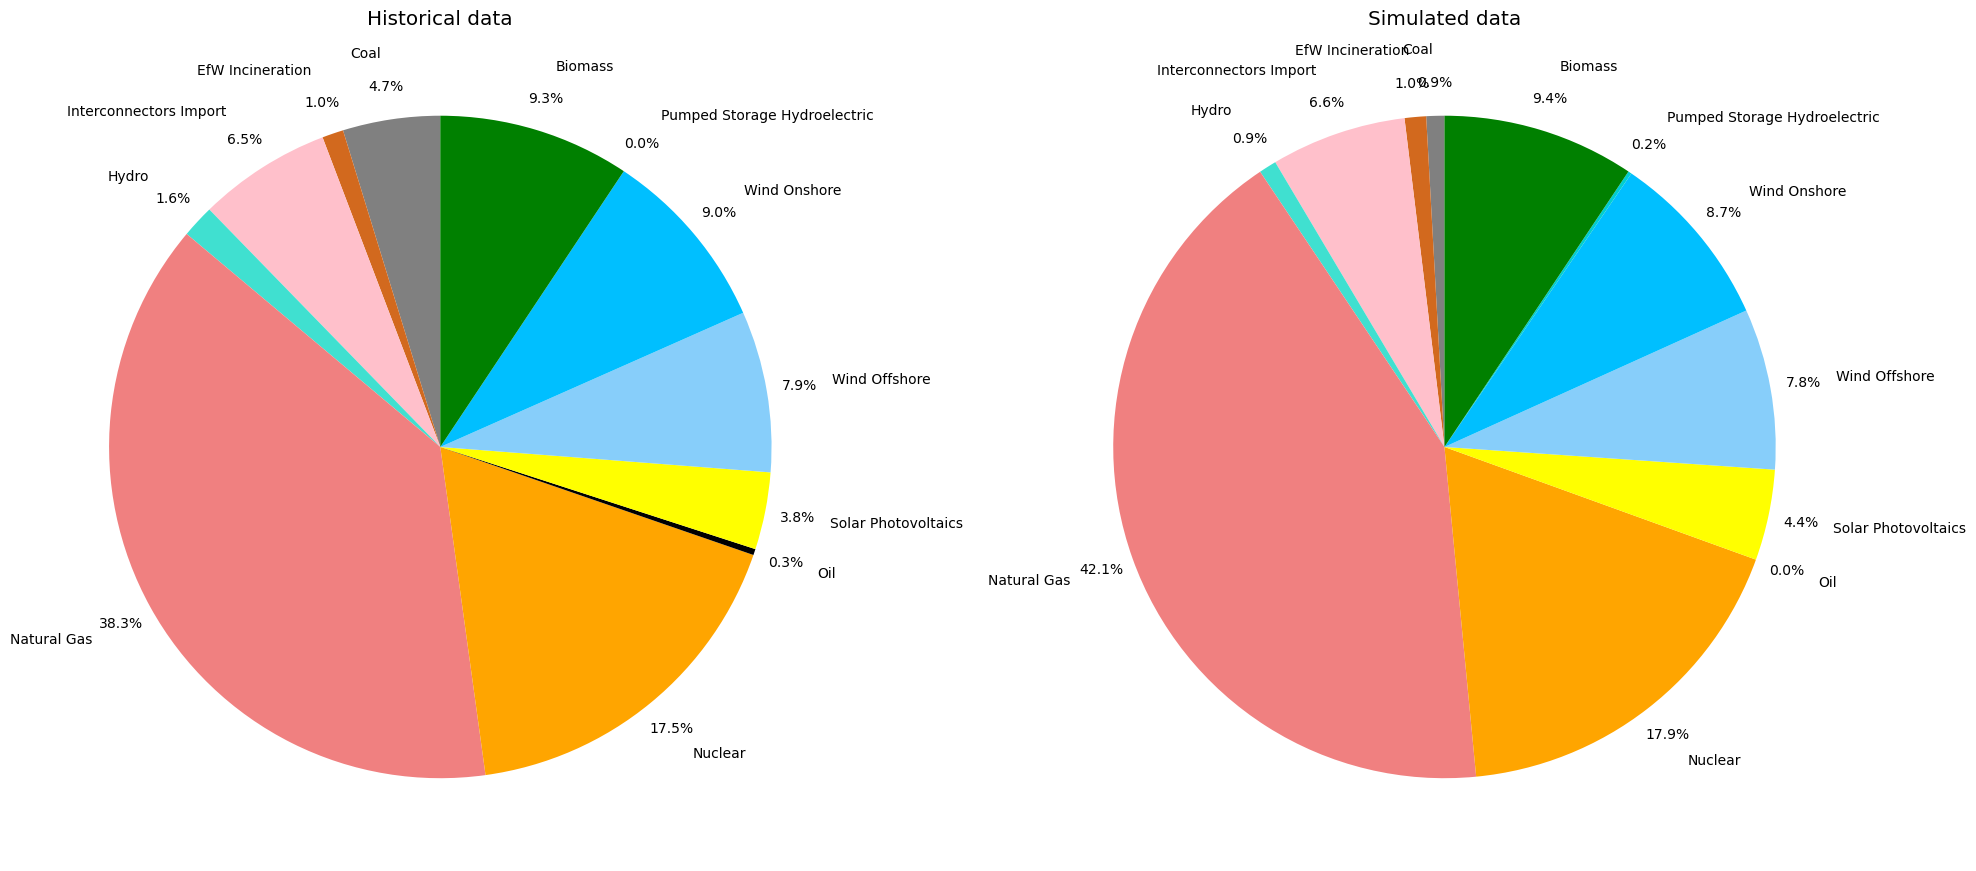

In [16]:
# mylabels = data_series.index
# mycolors = categorical_cmap(3, 10)

colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,15)

ax1.pie(data_series, labels=data_series.index,
        colors=[colors[col] for col in p_by_carrier.index], autopct="%1.1f%%",
        startangle=90, pctdistance=1.1, labeldistance=1.2)
ax1.set_title('Historical data')

simulated_generation = p_by_carrier
ax2.pie(simulated_generation, labels=simulated_generation.index,
        colors=[colors[col] for col in p_by_carrier.index], autopct="%1.1f%%",
        startangle=90, pctdistance=1.1, labeldistance=1.2)
ax2.set_title('Simulated data')

plt.tight_layout()

In [17]:
df = pd.DataFrame([simulated_generation, data_series], index=['Simulated', 'Historical']).T.round(1)
df.fillna(0, inplace=True)
df['Simulated - Historical'] = df['Simulated'] - df['Historical']
df['Simulated (%)'] = (df['Simulated'] / df['Simulated'].sum()* 100).round(1)
df['Historical (%)'] = (df['Historical'] / df['Historical'].sum()* 100).round(1)
df['Simulated (%) - Historical (%)'] = df['Simulated (%)'] - df['Historical (%)']
df.loc["Total"] = df.sum().round(2)
df

,Simulated,Historical,Simulated - Historical,Simulated (%),Historical (%),Simulated (%) - Historical (%)
Coal,2.9,16.0,-13.1,0.9,4.7,-3.8
EfW Incineration,3.5,3.5,0.0,1.1,1.0,0.1
Interconnectors Import,21.9,21.9,0.0,6.6,6.5,0.1
Hydro,2.8,5.4,-2.6,0.8,1.6,-0.8
Natural Gas,139.8,129.1,10.7,42.1,38.3,3.8
Nuclear,59.6,59.1,0.5,18.0,17.5,0.5
Oil,0.0,1.0,-1.0,0.0,0.3,-0.3
Solar Photovoltaics,14.7,12.7,2.0,4.4,3.8,0.6
Wind Offshore,26.0,26.5,-0.5,7.8,7.9,-0.1
Wind Onshore,28.9,30.4,-1.5,8.7,9.0,-0.3


Looking at table above we can see (i) Gas too high, and (ii) Coal too low.

Likely due to price dynamics of gas and coal which are not fully captured in marginal cost, e.g., capacity markets.

Coal                    16.0
EfW Incineration         3.5
Interconnectors         21.9
Hydro                    5.4
Natural Gas            129.1
Nuclear                 59.1
Oil                      1.0
Solar Photovoltaics     12.7
Wind Offshore           26.5
Wind Onshore            30.4
Pumped Storage           0.0
Biomass                 31.5
dtype: float64


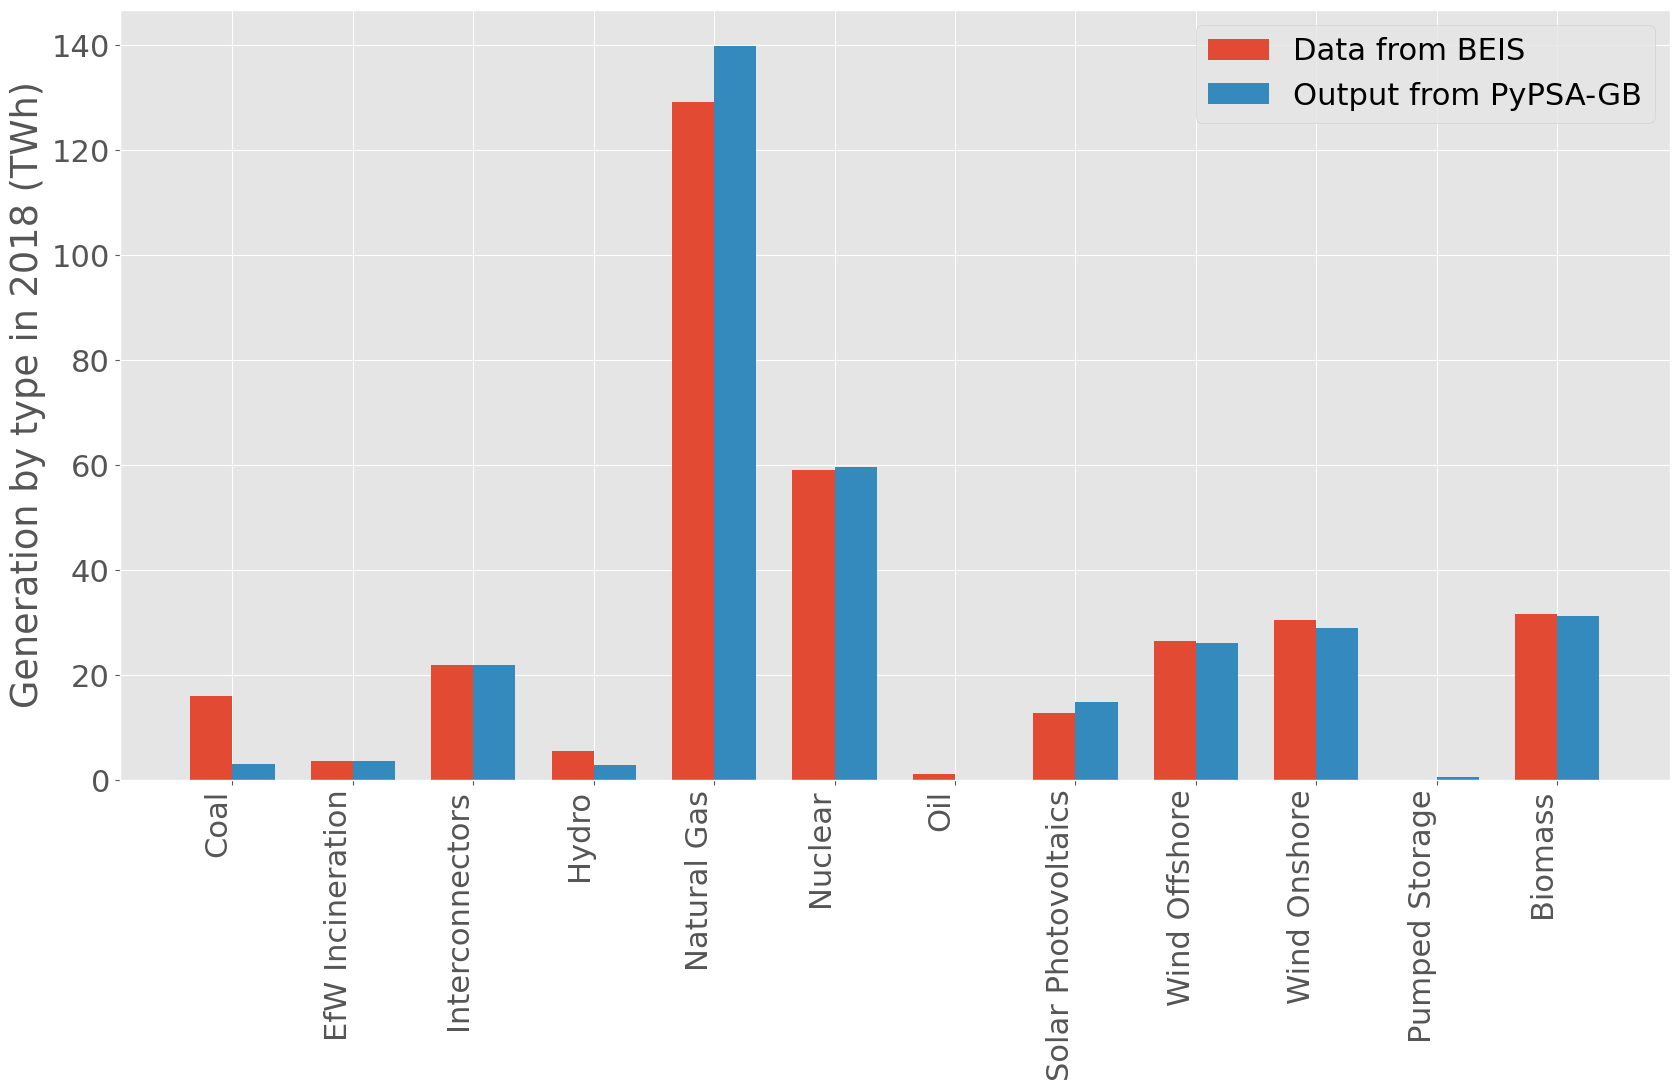

In [25]:
N = len(data_series.index)
data_series.rename({'Pumped Storage Hydroelectric': 'Pumped Storage'}, inplace=True)
data_series.rename({'Interconnectors Import': 'Interconnectors'}, inplace=True)
print(data_series)
data = data_series.values
sim = p_by_carrier.values

ind = np.arange(N) 
width = 0.35
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.bar(ind, data, width, label='Data from BEIS')
plt.bar(ind + width, sim, width, label='Output from PyPSA-GB')

plt.ylabel('Generation by type in 2018 (TWh)')
# plt.title('Scores by group and gender')

plt.xticks(ind + width / 2, data_series.index)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.legend(loc='best')
plt.show()